### Project 1: Data Exploration, Visualization and Dimensionality Reduction
## Animal Shelter Outcomes: A Classification Problem
#### Alex Matsunami, RJ Smith, Cory Nichols

## Business Understanding


Millions of animal companions end up in shelters each year in the United States. These animals may be stray, rescued from a difficult situation or given up by their previous families. Each year, roughly 40 percent of all dogs and cats in shelters are euthanized. 

Our dataset comes from the Austin Animal Center in Austin, Texas and is part of a Kaggle competition. Using this data, we hope to find trends or rule sets identifying the outcomes of animals in shelters. The findings would subsequently drive shelter practices, hopefully for more social good than business good. For instance, if spaying or neutering a dog or cat is highly suggestive of a favorable outcome for an animal, shelters should implement policies ensuring all animals are fixed prior to adoption. This practice may cost the shelter more money, but would improve the welfare of the animal population. Further, could something as simple as giving each an animal a name drive a more favorable outcome? This particular practice would cost nothing but time and in turn improve the welfare of the animal population in cities. Cost savings, however, could be gained from our analysis. For instance, it may be easy enough to automate intake and processes for certain breeds or genders of animals while focusing attention on breeds or genders of animals that the data indicate "need more help."

We intend to use the 27 thousand records in the training set as a reference for other major cities in the United States, where most animal shelter practices are similar from an intake and outcome perspective. Our dataset includes statistics on breed, color, sex, and age from the Austin Animal Center.

Success should be categorized into analytical and business goals. Analytical goals would be based on classification accuracy on a sizeable test data set given by a confusin matrix where overall classification accuracy is greater than 85% at minimum with at least 85% precision. Further, and possibly more importantly, we hope our analysis drives at least a 20% decrease in animal euthanizations over a two calendar year period.  


## Data Meaning and Data Types  (Add Info Here)

## Data Preprocessing: Transformation and Statistics 

In [173]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler,Imputer
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [174]:
df = pd.read_csv('~/desktop/train.csv')
breedMap = pd.read_csv('~/desktop/breed_size.csv')


Our dataset is made up of 10 variables, many of which can be split or transformed into additional variables. Further, the majority of the variables are categorical: mostly nominal variables except for ordinal variables like Age and temporal variables like DateTime. Some variables, such as AnimalID, will provide no value in our analysis.

Our class variable is OutcomeType. We are interested in classifying animal outcome types given the other explanatory variables, which we will elaborate upon further.


In [175]:
df.head(3)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


### Data Quality and Cleanup

In [176]:
print 'Data types and counts:\n\n', df.info(), '\n\n'
print 'Number of nulls in the data set: \n', df.isnull().sum(),'\n\n'
print '\Data Descriptions: Counts, Frequency'

df.describe()

Data types and counts:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.2+ MB
None 


Number of nulls in the data set: 
AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64 


\Data Descriptions: Counts, Frequency


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824



Based upon the information retrieved from the DataFrame, we are dealing with roughly 27 thousand records in the training set. We are only interested in the "OutcomeType" as our y (classifier) data. Outcome subtype is a sparse drill down on the Outcome type with sub-codes which are not explained thoroughly. Therefore, we recommend dropping this value as it is aub-variable of the outcome variable we are interested with roughly 50% valid values.

The good news is: 40% of animals are being adopted, most of which are neutered male dogs about a year old. 

In regard to new feature creation, we observe multiple opportunities. For instance, it will be interesting to see if having a name affects outcome and if the type of breed is aggressive (has a "reputation"). We can also see converting the AgeuponOutcome being valuable. 

However, before we create or transform features, let's clean up the data a bit more. There are a few nulls in our dataset. Of concern are the nulls in AgeuponOutcome and SexuponOutcome, in which there are 18 and 1 null values, respectively. This is not a large concern given the size of our dataset and what looks to be good quality data overall. However, we will attempt to keep the age nulls in the dataset. Losing one object in the dataset due a null in SexuponOutcome is not a concern. Because we care about whether or not a pet is named, the nulls in Name are not a concern. Further, OutcomeSubtype is simply a click down of OutcomeType, which is our classifier, and is quite sparse. We are dropping OutcomeSubtype, we are not concerned with the nulls.


In [177]:
del df['OutcomeSubtype'], df['AnimalID'] # drop extraneous data  columns
df = df.dropna(subset=['SexuponOutcome']) # drop the one nan row in the sex column. Not a large impact to analysis.
df = df.reset_index() # reset index to ensure further operations are executed correctly

Categorical Filling Strategy:
Fill the nulls with top 3 categories in a column vector randomly for age and sex.
Outside of the nulls, there is a string for age: "0 years" with 22 instances. This provides about "0" value. We will also fill "unknowns" in the sex column vector with the same logic. We will fill these columns by iterating over and randomly choosing one value of the top 3 values instead of assigning an arbitrary value. We believe this is relevant because the top 3 categories are spread relatively similarly, with roughly similar percentages of each column vector.

In [178]:
from collections import Counter
from random import randint
# pandas groupby - group dataset by common attributes - what's the mode 
print 'Number of unique, non nan ages:', len(np.unique(df.AgeuponOutcome[~pd.isnull(df['AgeuponOutcome'])])) 

randChooser = []
for i in ['AgeuponOutcome', 'SexuponOutcome']:
    randChooser.append(Counter(df[i].values).most_common(3)) # get the 3 most common categories

df['AgeuponOutcome'] = [randChooser[0][randint(0,2)][0] # randomly pick one of the three categories and replace null
                        if pd.isnull(i) or i.lower() == '0 years' else i for i in df['AgeuponOutcome'].values]
 
df['SexuponOutcome'] = [randChooser[1][randint(0,2)][0]\
                        if i.lower() == 'unknown' else i for i in df['SexuponOutcome'].values]

Number of unique, non nan ages: 44


In [179]:
del df['index']
print 'Number of nulls in the data set: \n', df.isnull().sum(),'\n'
df.head()

Number of nulls in the data set: 
Name              7691
DateTime             0
OutcomeType          0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       0
Breed                0
Color                0
dtype: int64 



,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Data Creation and Transformation


All columns outside of the name column are now non-null.

Let's create some useful variables in our data set. It would be interesting to investigate whether or not a potential adoptee having a name has an effect on their outcome.

The gender and what we will call "is_intact" (whether an animal is intact (not fixed)) are also interesting variables to investigate.

Further, it would be better to represent age as a continuous ratio variable. We will transform age into day and check it's distribution for normality.


In [180]:
print 'There are %d unique names in the data set' % len(np.unique(df['Name'].values))

# 6375 unique names. That is quite a few names. Let's generalize into a binary feature called has_name instead:
# per Eric's feedback, use pandas functionality instead and do this more efficiently vs pure python list comps:

df['has_name'] = df['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Further, let's split out the intactness of an animal: whether or not the animal has been spayed or neutered
# as well as the gender:

intactness = lambda x: 'Fixed' if x.split()[0] in ['Spayed','Neutered'] else 'Intact'
df['is_intact'] = df['SexuponOutcome'].apply(intactness)

df['gender'] = df['SexuponOutcome'].apply(lambda x: x.split()[1])

# we will also convert ageuponoutcome into days:
df['AgeValue'] = df['AgeuponOutcome'].apply(lambda x: x.rstrip('s').split())
            
ageMap = {'year': 365, 
          'week': 7, 
          'month': 30,
          'day': 1} 

df['AgeValue'] = df['AgeValue'].apply(lambda x: ageMap.get(x[1])*int(x[0]))

There are 6375 unique names in the data set



Let us also identify potentially 'aggressive' breeds using a bit of regex and top 10 aggressive breeds list: 
http://www.therichest.com/rich-list/the-biggest/the-worlds-10-most-dangerous-dog-breeds/?view=all


In [181]:
import re

agg_breeds = ['Bull','Doberman','Rottweiler','Husky','German','Boxer','Malamute','Dane']

df['is_aggressive'] = [re.split('\W+',i) for i in df['Breed']]

for idx, i in enumerate(df['is_aggressive'].values):
    if len(agg_breeds) != len(set(agg_breeds).difference(i)):
        df.set_value(idx, 'is_aggressive', 1)
    else:
        df.set_value(idx, 'is_aggressive', 0)      

Let's also grab the primary color using same regex approach and reduce the number of categories in color

In [182]:
colorMap = {'exotic':['Agouti','Calico','Lynx','Tricolor','Tortie','Flame','Torbie'], # these are some odd colors...
            'dark':['Black','Chocolate','Liver','Sable','Seal','Red'],
            'neutral':['Gray','Silver','Tan','Buff','Brown','Fawn'],
            'light':['Cream','Blue','Pink','White','Yellow','Lilac','Ruddy','Apricot','Orange','Gold']}
# use pandas built ins to munge the data a bit faster - use rename, split_interval to convert age
# 
df['primary_color'] = [re.split('\W+',i)[0] for i in df['Color']]

for idx, color in enumerate(df['primary_color'].values):
    for k,v in colorMap.items():
        if color in v:
            df.set_value(idx,'primary_color', k)

One other critical attribute we are missing is animal size. We assume the size of an animal is extremely important, especially when it comes to adopting dogs. Therefore, we have retrieved the American Kennel Club's (http://www.akc.org/dog-breeds/) listing of breeds and associated sizes. Because there are so few toy breeds listed, we combined toy and small into "small." For breeds that were not represented in AKC's list (there were about 20), each  was mapped to size buckets based on the following logic: Small (avg weight <= 20 lbs ), Medium (<= 65 lbs), Large (<= 100 lbs), Giant (> 100 lbs). All cats were mapped to "small." We expect the size feature to be more relevant for dogs, and we expect it to be significant. We've also added in an indicator for the top 10 most popular dogs.

In [183]:
# set primary breed as the lookup
df['BreedLU'] = [i.rstrip('Mix').split('/')[0].strip() for i in df['Breed']] 

# zip up breed and size into a dict
sizeMapper = dict(zip(breedMap['Breed'], breedMap['Size'])) 

# map it, I love Pandas
df['size'] = df['BreedLU'].map(sizeMapper) 
df['size'] = np.where(df['AnimalType'].values == 'Cat', 'Small', df['size']) # set cats to small (unless Garfield)
del df['BreedLU'] # drop the lookup vector

In [184]:
# Source: http://www.petinsurance.com/healthzone/pet-articles/pet-breeds/Top-10-Dog-Breeds.aspx
topBreeds = ['Boxer', 'Rottweiler', 'Poodle', 'Yorkshire Terrier',
                'French Bulldog', 'Beagle', 'Bulldog',
                'Golden Retriever', 'German Shepherd', 'Labrador Retriever']

topBreedList = []
for i in df['Breed']:
    matched = False
    for topBreed in topBreeds:
        if topBreed in i:
            topBreedList.append(1)
            matched = True
            break
    if not matched:
        topBreedList.append(0)       

df['is_popular'] = topBreedList

Now that we've transformed our dataset. Let's drop a few extraneous columns such as SexUponOutcome, since it is now split between is_intact and gender.

## Variable Investigation And Single Variable Data Visualization

First, let's convert categorical features to objects and make column names a little easier to follow:

In [185]:
df.columns = ['Name','DateTime','Outcome','Type','SexuponOutcome','AgeuponOutcome','Breed','Color','Has_Name',
              'Is_Intact','Gender','Age_Value','Is_Aggressive','Primary_Color','Size', 'Is_Popular']

categ = ['Type','Breed','Is_Intact','Gender','Is_Aggressive', 'Primary_Color', 'Size','Has_Name',
         'Outcome','Is_Popular']
df[categ] = df[categ].astype(np.object)
df[categ].describe()

,Type,Breed,Is_Intact,Gender,Is_Aggressive,Primary_Color,Size,Has_Name,Outcome,Is_Popular
count,26728,26728,26728,26728,26728,26728,26727,26728,26728,26728
unique,2,1380,2,2,2,4,4,2,5,2
top,Dog,Domestic Shorthair Mix,Fixed,Male,0,dark,Small,1,Adoption,0
freq,15594,8810,19317,14042,22372,8487,17156,19037,10769,21702


The data is starting to tell more of a story with our transformed dataset. There are no longer nulls and it looks as if mostly small dogs with names make up a good portion the data set. Nearly 70% of animals in our dataset are fixed. Interestingly, domestic shorthair mixes dominate the data set from a breed perspective, which have 1380 unique values. This may be a "catch all" breed used to identify dogs the shelter had trouble identifying and may be a future issue from a classification standpoint.

We also transformed the age variable into a continuous feature. Let's ensure it has a valid data type and quickly take a look at its distribution and some other key statistics.

In [186]:
df['Age_Value'] = df['Age_Value'].astype(float)
df['logAge'] = np.log(df['Age_Value']).astype(float)
df['sqrtAge'] = np.sqrt(df['Age_Value']).astype(float)
df[['Age_Value','logAge','sqrtAge']].describe()

,Age_Value,logAge,sqrtAge
count,26728.000000,26728.000000,26728.000000
mean,794.135251,5.648944,22.753016
std,1082.334561,1.662277,16.626661
min,1.000000,0.000000,1.000000
25%,60.000000,4.094345,7.745967
50%,365.000000,5.899897,19.104973
75%,1095.000000,6.998510,33.090784
max,7300.000000,8.895630,85.440037


On average, animals are about two years old when adopted. Based simply on the range, age needs to be transformed if we are to use it as a continuous variable. Some animals are one day old upon outcome, while some are as old as 7300 days (20 years!). We will attempt two common methods: the natural log and square root transforms. We will use these transformations for ease of explanation to the business when back transforming and ensuring a more normal distribution for use in classification algorithms. 

Because age was technically a many-leveled categorical variable transformed to a continuous variable, we expect to see a stepped distribution. Because of this we will likely run algorithms with both the continuous and categorical versions of age.

First lets look at the original distribution of age, the log age and sqrt of age in violin plots:

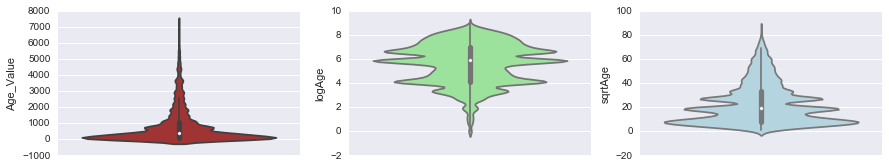

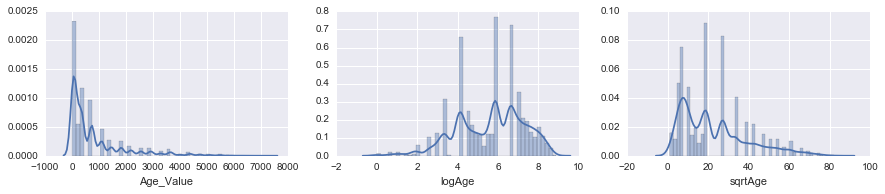

In [187]:
from random import random
c = ['firebrick','lightgreen','lightblue']
atts = ['Age_Value','logAge','sqrtAge']

for i in range(2):
    plt.figure(figsize=(20,15))
    for index, plots in enumerate(atts):
        plt.subplot(5, 4, index + 1) # plot them all on one row
        if i == 0:
            sns.violinplot(y = plots, data= df, color = c[index])
        else: sns.distplot(df[plots])
plt.show()

Violin plots allow us to account for multi-modality while also giving us standard box plot information. These charts plot kernel density estimates on each side of the box plot. As we can see above, our data is very much multi modal.  We also plot histograms and overlayed KDEs and end up with the same outcome. Let's also look at EDFs and normality tests to confirm a lack of age normality:

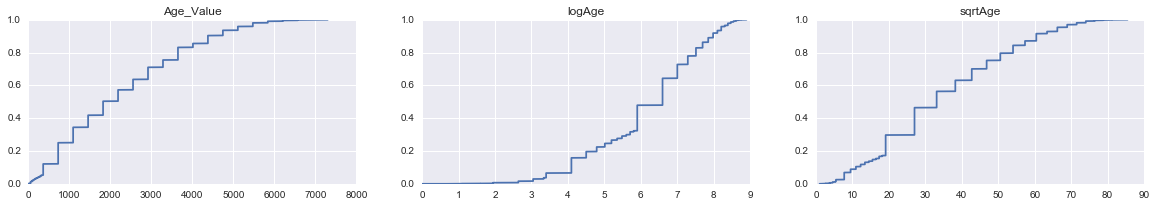

In [188]:
plt.figure(figsize=(20,10))
for index, feature in enumerate(['Age_Value','logAge','sqrtAge']):
    plt.subplot(3, 3 , index + 1)
    x_ax = np.sort(df[feature]) # sort the feature ascending
    y_ax = np.cumsum(x_ax) # take cumulative sum, this creates an array of each observation adding to total sum
    y_ax = y_ax / np.max(y_ax) # get each observation's percentage of total sum of attribute
    plt.plot(x_ax,y_ax) # plot it
    plt.title(feature) # give it a title
    
plt.show()

# It's pretty apparent age is not normally distributed and the transforms dont do much to help us.

In [189]:
from scipy.stats import normaltest
vars = ['Age_Value','logAge','sqrtAge']
for i in vars:
    print i.ljust(10), 'chi-square:', round(normaltest(df[i])[0]), '\tp-value: {:.2f}'.format(normaltest(df[i])[1])

Age_Value  chi-square: 11283.0 	p-value: 0.00
logAge     chi-square: 916.0 	p-value: 0.00
sqrtAge    chi-square: 3270.0 	p-value: 0.00


As shown above, the numerically converted Age is right skewed with a median value of about 365 days. This skewness is attributed to the younger ages of adopted animals. Empirical distribution functions show our data in a more quantitative fashion: showing probabilities of of obtaining values on the y axis and the value range itself on the x-axis. For instance, there is roughly an 85% chance of finding an age less than 4000 days in our dataset. We are looking for a relatively smooth upward curve that is not skewed severely 

Transforming the feature Age into a log representation and sqrt representation doesn't provide gaussian distributions, confirmed by EDF plots and D'Agostino's normal test. Depending on the classification algorithm used, we will likely need to utilize a categorical variable with levels for Age. 

In [190]:
# let's convert age to an age range, if an animal is a year or less: young, up to 8 years: adult, 8+ years: senior
df['age_range'] = pd.cut(df.Age_Value/365,[0, 1, 8, 1e6],3, labels=['young', 'adult', 'senior'])
del df['logAge']
del df['sqrtAge']

Now that we've thoroughly analyzed and visualized age, we will move on to categorical variables. The rest of our dataset is primarily categorical (both nominal and ordinal variables). Visualizations of counts will be the priority. Of interest in particular are the variables we spent a significant amount of time creating, such as size and aggressive breeds.

To be thorough let's go ahead and plot percentage bars and investigate counts, which is common for individual categorical variables:

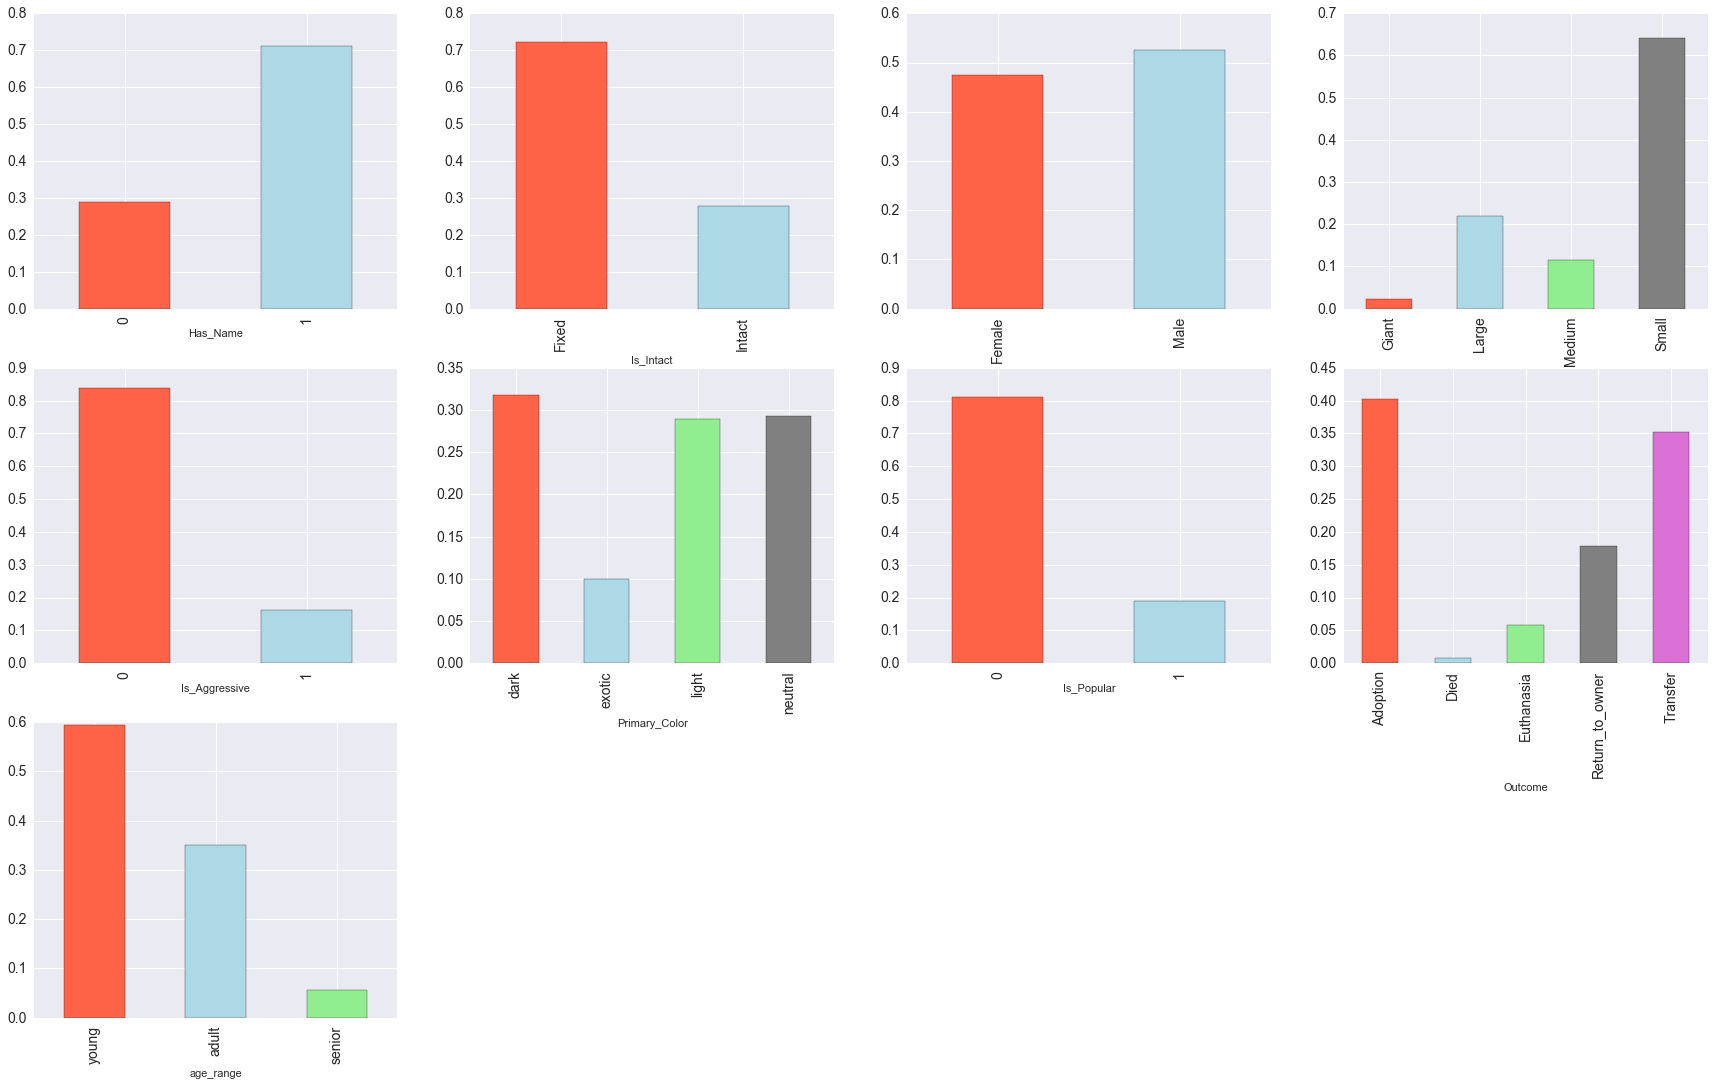

In [191]:
import matplotlib

features = ['Has_Name','Is_Intact','Gender','Size','Is_Aggressive','Primary_Color', 'Is_Popular','Outcome','age_range']

plt.figure(figsize=(30,18))
for index, feature in enumerate(features):
    plt.subplot(3, 4, index +1)
    groups = df.groupby(feature)['Outcome'].count()/len(df)
    ax = groups.plot(kind = 'bar', color =['tomato','lightblue','lightgreen','gray','orchid'], fontsize=14)

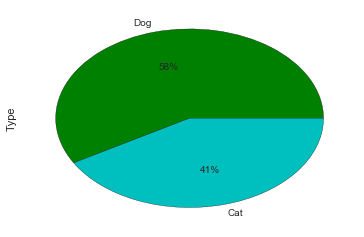

In [192]:
df.Type.value_counts().plot(kind='pie', autopct='%1d%%', colors = ['g', 'c'])

Some interesting discoveries come out of simple percentages: for instance, most animals being adopted are small. This is likely because cats are also categorized into the small category -- we will explore animal type crosstabs more thoroughly. Most critically, adoption rates show promise: 40 percent of all animals are adopted. Our business partners are looking to increase this number. Further, given Austin's policy of no euthanizations unless aggressive or sick, it's easy to see that most animals do indeed survive, however, most are transferred to other shelters. Transfers come with high cost for our business partners. This is likely a metric they'd like to reduce. The more an animal is passed through the system, the larger emotional detriment and the higher cost for the shelters in managing input/output as well as standard medical treatment, room and board and surgical operations. Further, it looks as though the most popular breeds are not present in the sample of shelter animals, which could be a bad sign for future adoptability.

Based on these charts, we also likely can combine size into a three level factor feature by combining giant into large since it is about 2% of the dataset. Further, most animals are dark colored and fixed. Fixed animals make up almost 75% of the dataset while dark colored animals are 40% of the sample size.

Further, there are more dogs than cats in our dataset. This is actually a surprise, given that stray cats are far more frequently encountered than stray dogs. 

## Feature Relationships, Correlative Analysis and Further Visualizations

Visualizing relationships of categorical variables can be difficult in some instances. However, we're going to start with a mosaic plot (tree map) to show relative sizes of categorical variables and how they interact with one another. First, we are going to investigate the type of animal, split and sized by Is_Intact and Size

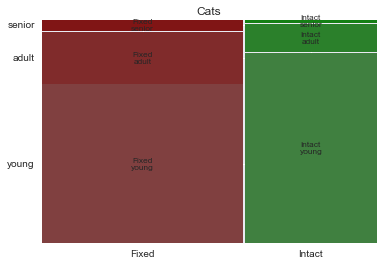

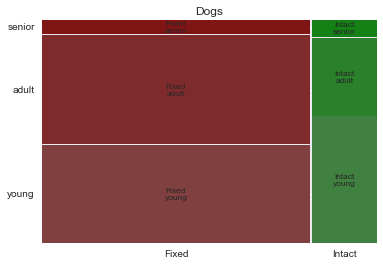

In [193]:
# mosaic plot for dogs on size and color
from statsmodels.graphics.mosaicplot import mosaic
for i in np.unique(df['Type']):
    mosaic(df[df['Type'] == i], ['Is_Intact','age_range']),
    plt.title(i+'s')
    plt.show()

We immediately see that most animals are fixed, which is something we could tell with univariate analysis. However, for both dogs and cats, we notice that younger animals in general have a higher rate of being intact. This is likely because the animals are new arrivals, however, our dataset does not contain temporal data in order to determine this effect. 

Is_Aggressive          False      True 
Size   age_range                       
Giant  young       71.147541  28.852459
       adult       53.535354  46.464646
       senior      48.571429  51.428571
Large  young       42.121849  57.878151
       adult       33.395314  66.604686
       senior      49.834983  50.165017
Medium young       85.490932  14.509068
       adult       83.436533  16.563467
       senior      88.205128  11.794872
Small  young       98.848750   1.151250
       adult       99.392713   0.607287
       senior     100.000000   0.000000


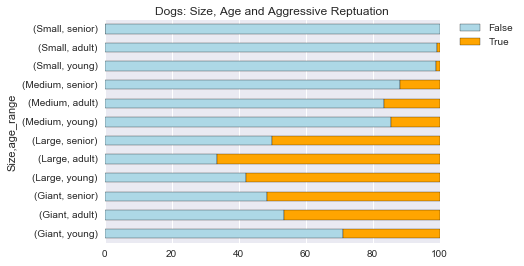

In [194]:
dfdogs = df[df.Type == 'Dog']
dogs = pd.crosstab([dfdogs['Size'], dfdogs['age_range']], dfdogs.Is_Aggressive.astype(bool))
dogs_rate = dogs.div(dogs.sum(1).astype(float), axis=0)*100
print dogs_rate
dogs_rate.plot(kind='barh', stacked=True, color =['lightblue','orange'], legend=False)
plt.title('Dogs: Size, Age and Aggressive Reptuation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Here, we are looking at dog age ranges and aggressiveness. Some interesting trends are readily apparent: large, adult dogs tend to be more 'aggressive' breeds, even moreso than giant dogs. 

## Additional Work: Algorithmic Setup

In [195]:
#df2 = df

sizeMap = {'Giant':4,'Large':3,'Medium':2,'Small':1}
df['Size'] = df['Size'].map(sizeMap)

df = df.join(pd.get_dummies(df['Primary_Color']))
df = df.join(pd.get_dummies(df['Type']))

classLabels = LabelEncoder()
df['Outcome_Label'] = classLabels.fit_transform(df['Outcome']) 


In [196]:
# Cory aint ready...
from sklearn.cluster import spectral_clustering
graph = df[['Type','Age','Color','Has_Name','Intact','Gender','Is_Aggressive','Primary_Color','Size']]
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')

KeyError: "['Age' 'Intact'] not in index"